Everything on the shapefile map and output data in shapefile format.

1) Feb 2021 event (February 13–17, 2021 North American winter storm):
 - One plot per day:
 - Daily Tmax
 - Daily Tmin
 - Daily precip tot
 - Daily (precip.and.Tmin<0)  so where(Tmin>0,precip@_FillValue)
 - One plot for the whole event->
   Number of days with Tmin<0 for the event

2) June 2021 heatwave (June 27 - June 30)

One plot per day:
Daily Tmax
Daily Tmin


In [1]:
# Mask PRISM data with shapefile

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from importlib import reload
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine
import geoplot as gplt
from importlib import reload

# in a Jupyter notebook: “magic” command to render plots properly:
%matplotlib inline

import innovator_func
reload(innovator_func)
from innovator_func import transform_from_latlon
from innovator_func import rasterize
from innovator_func import add_shape_coord_from_data_array
from innovator_func import create_shape_2d

In [2]:
def plot_cho_p(da_4d, var_s, shp_raster_2d, lat_centroid, lon_centroid, cmap_s):
    '''
    da_4d: dataArray(n_var, n_day, n_lat, n_lon)
    shp_raster_2d: dataArray of rasterized shapefile on da_4d grid
    '''
    n_var = len(var_s)
    n_day = len(da_4d[0,:,0,0])
    fig, ax = plt.subplots(n_day, n_var, figsize=(24,25))

    for nv in range(n_var):
        arr_2d = create_shape_2d(da_4d[nv], shp_raster_2d, lat_centroid, lon_centroid)
        for nd in range(n_day):
            shp_gpd[var_s[nv]] = arr_2d[nd]

            gplt.choropleth(shp_gpd, 
                            hue=var_s[nv], 
                            edgecolor="black",
                            linewidth=0.5, cmap=cmap_s[nv], #'inferno_r', #"Pastel2", #"Greens",
                            legend=True,
                            scheme="FisherJenks",
                            #hatch='///',
                            ax=ax[nd][nv])
            plt.title(var_s[nv] + ' day ' + str(nd));
    plt.tight_layout()
    
def plot_shp_p(da_4d, var_s, shp_raster_2d, lat_centroid, lon_centroid, cmap_s, date_s):
    '''
    da_4d: dataArray(n_var, n_day, n_lat, n_lon)
    shp_raster_2d: dataArray of rasterized shapefile on da_4d grid
    '''
 
    n_var = len(var_s)
    n_day = len(da_4d[0,:,0,0])
    
    fig, ax = plt.subplots(n_day, n_var, figsize=(24,25))
     
    for nv in range(n_var):
        # for Tmax, Tmin
        if nv == 0 or nv == 1:
            vmin = -12
            vmax = 12
            # Summer
            #vmin = 10
            #vmax = 45
        # For Prec    
        else:
            vmin = 0
            vmax = 30
        
        arr_2d = create_shape_2d(da_4d[nv], shp_raster_2d, lat_centroid, lon_centroid)
        for nd in range(n_day):
            shp_gpd[var_s[nv]] = arr_2d[nd]

            # plotting with missing value 
            shp_gpd[shp_gpd[var_s[nv]].notna()].plot(ax=ax[nd][nv],cmap=cmap_s[nv],
                                                     edgecolor="black",linewidth=0.5,
                                                     vmin = vmin, vmax = vmax,
                                                     column=var_s[nv], legend=True) 
            ax[nd][nv].set_title(var_s[nv] + '  ' + date_s[nd]);
    plt.tight_layout()

In [3]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'

####  geospatial plot
Because of high resolution shapefile, there is no PRISM grid inside a lot of shapes. I calculate the centroid of those polygons and then use the nearest prism grid data

In [4]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/counties.shp'
flnm_shp = '/glade/work/mingge/SHAPEFILES/ncar_oregon_area/ncar_oregon.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

/glade/scratch/mingge/ipykernel_109914/4181976892.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_109914/4181976892.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_109914/4181976892.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


In [5]:
#shp_gpd.plot()
# geopandas is built off pandas. It inherits most of the same functionality as a regular dataframe. 
shp_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   population    382 non-null    float64 
 1   GEOID         382 non-null    object  
 2   Shape_Leng    382 non-null    float64 
 3   Shape_Area    382 non-null    float64 
 4   geometry      382 non-null    geometry
 5   lon_centroid  382 non-null    float64 
 6   lat_centroid  382 non-null    float64 
dtypes: float64(5), geometry(1), object(1)
memory usage: 21.0+ KB


#### Ice Storm : February 13–17, 2021 North American winter storm
https://en.wikipedia.org/wiki/February_13%E2%80%9317,_2021_North_American_winter_storm

In [6]:
date_s = pd.date_range('2021-02-13', '2021-02-17', freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmax/PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice('2021-02-13', '2021-02-17')).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice('2021-02-13', '2021-02-17')).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PR/PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice('2021-02-13', '2021-02-17')).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR
 
ice_3d = prec_3d.where(tmin_3d<0, drop=False)
 
n_day = tmax_3d.shape[0]

#### create a county mask

In [7]:
# Create a new coord for the ds indicating whether or not it is inside the shapefile
ds_da = add_shape_coord_from_data_array(ds.isel(time=0).isel(rlat=slice(88,122), rlon=slice(26, 82)), shp_gpd, "county")
county_2d = ds_da.county
#county_2d.plot()

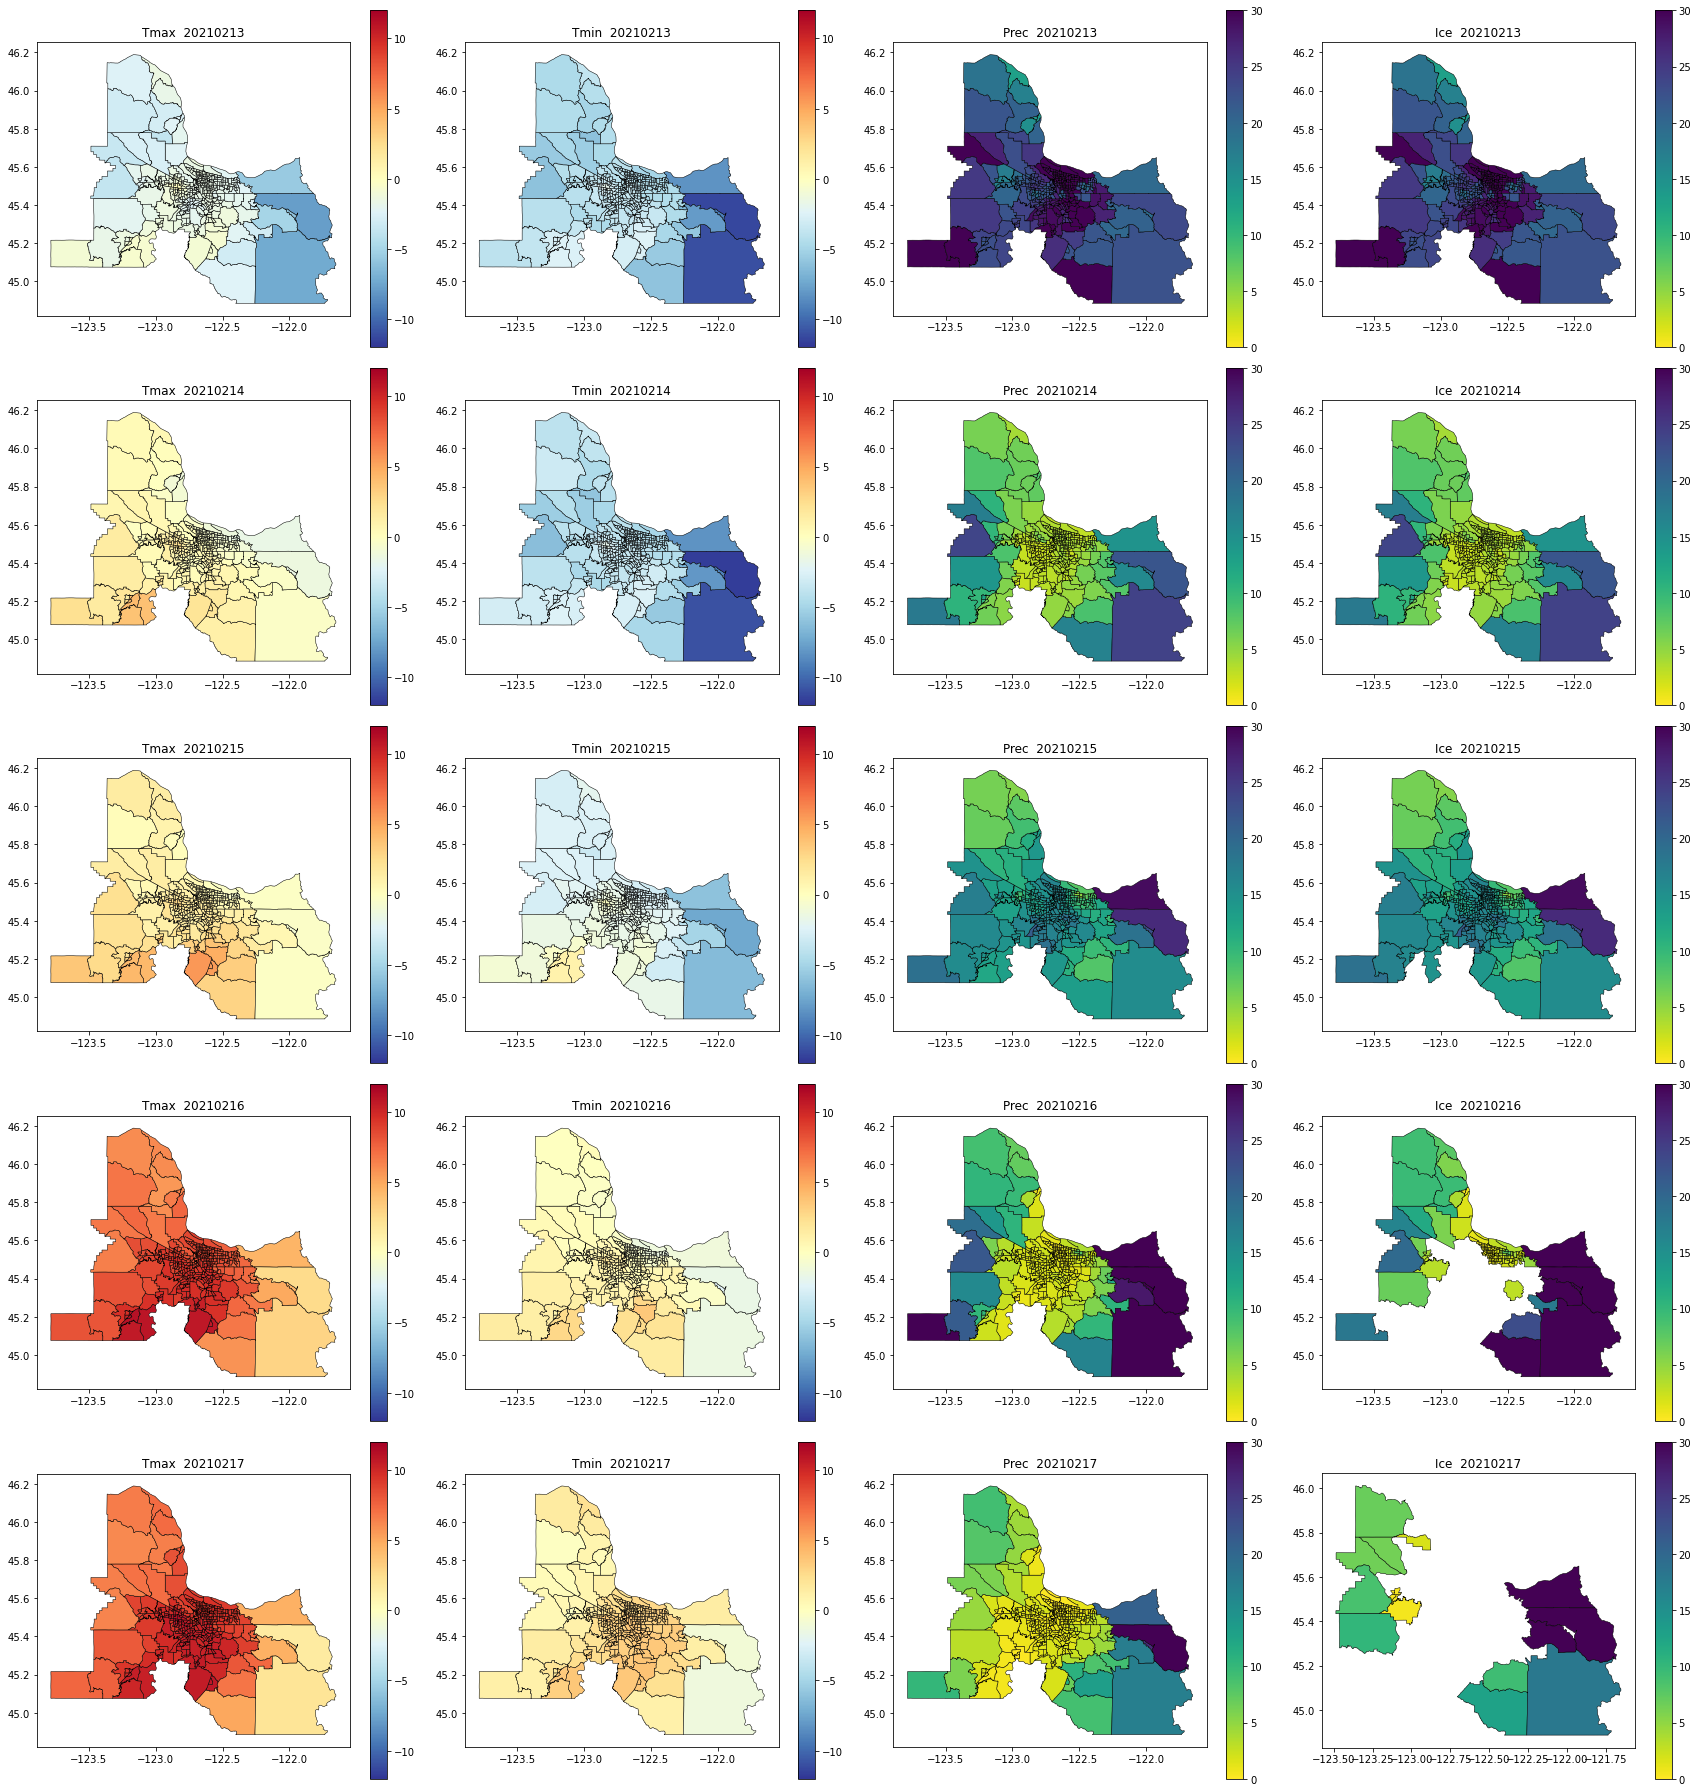

In [8]:
var_s = ['Tmax', 'Tmin', 'Prec', 'Ice']
cmap_s = ['plasma','plasma','viridis_r','viridis_r']
cmap_s = ['RdYlBu_r','RdYlBu_r','viridis_r','viridis_r']
n_var = len(var_s)
da_4d = xr.concat([tmax_3d, tmin_3d, prec_3d, ice_3d], "var_s")
 
plot_shp_p(da_4d, var_s, county_2d, shp_gpd.lat_centroid, shp_gpd.lon_centroid, cmap_s, date_s)

#### Number of days with Tmin<0 for the event

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


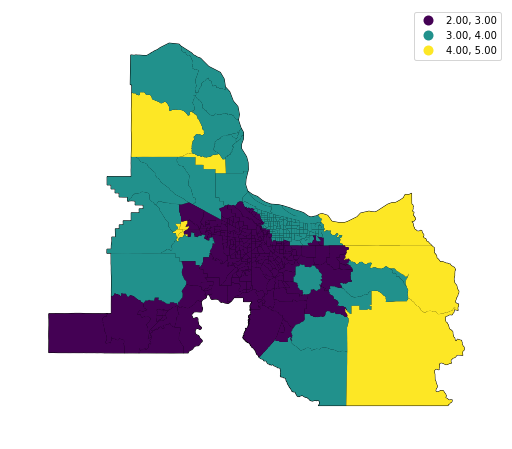

In [10]:
n_ice_3d = xr.where(tmin_3d<0, 1, 0)
n_ice_2d = n_ice_3d.sum(dim='time') 

list_1d = []

for nn in range(n_shp):
    t_mean = n_ice_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = n_ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['Nid'] = np.rint(np.asarray(list_1d))
shp_gpd['Nid'] = np.asarray(list_1d)

ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
shp_gpd.plot(ax=ax, column='Nid', legend=True, scheme="quantiles");


#### June 2021 heatwave (June 27 - June 30)

In [54]:
date_s = pd.date_range('2021-06-27', '2021-06-30', freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmax/PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice('2021-06-27', '2021-06-30')).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice('2021-06-27', '2021-06-30')).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

n_day = tmax_3d.shape[0]

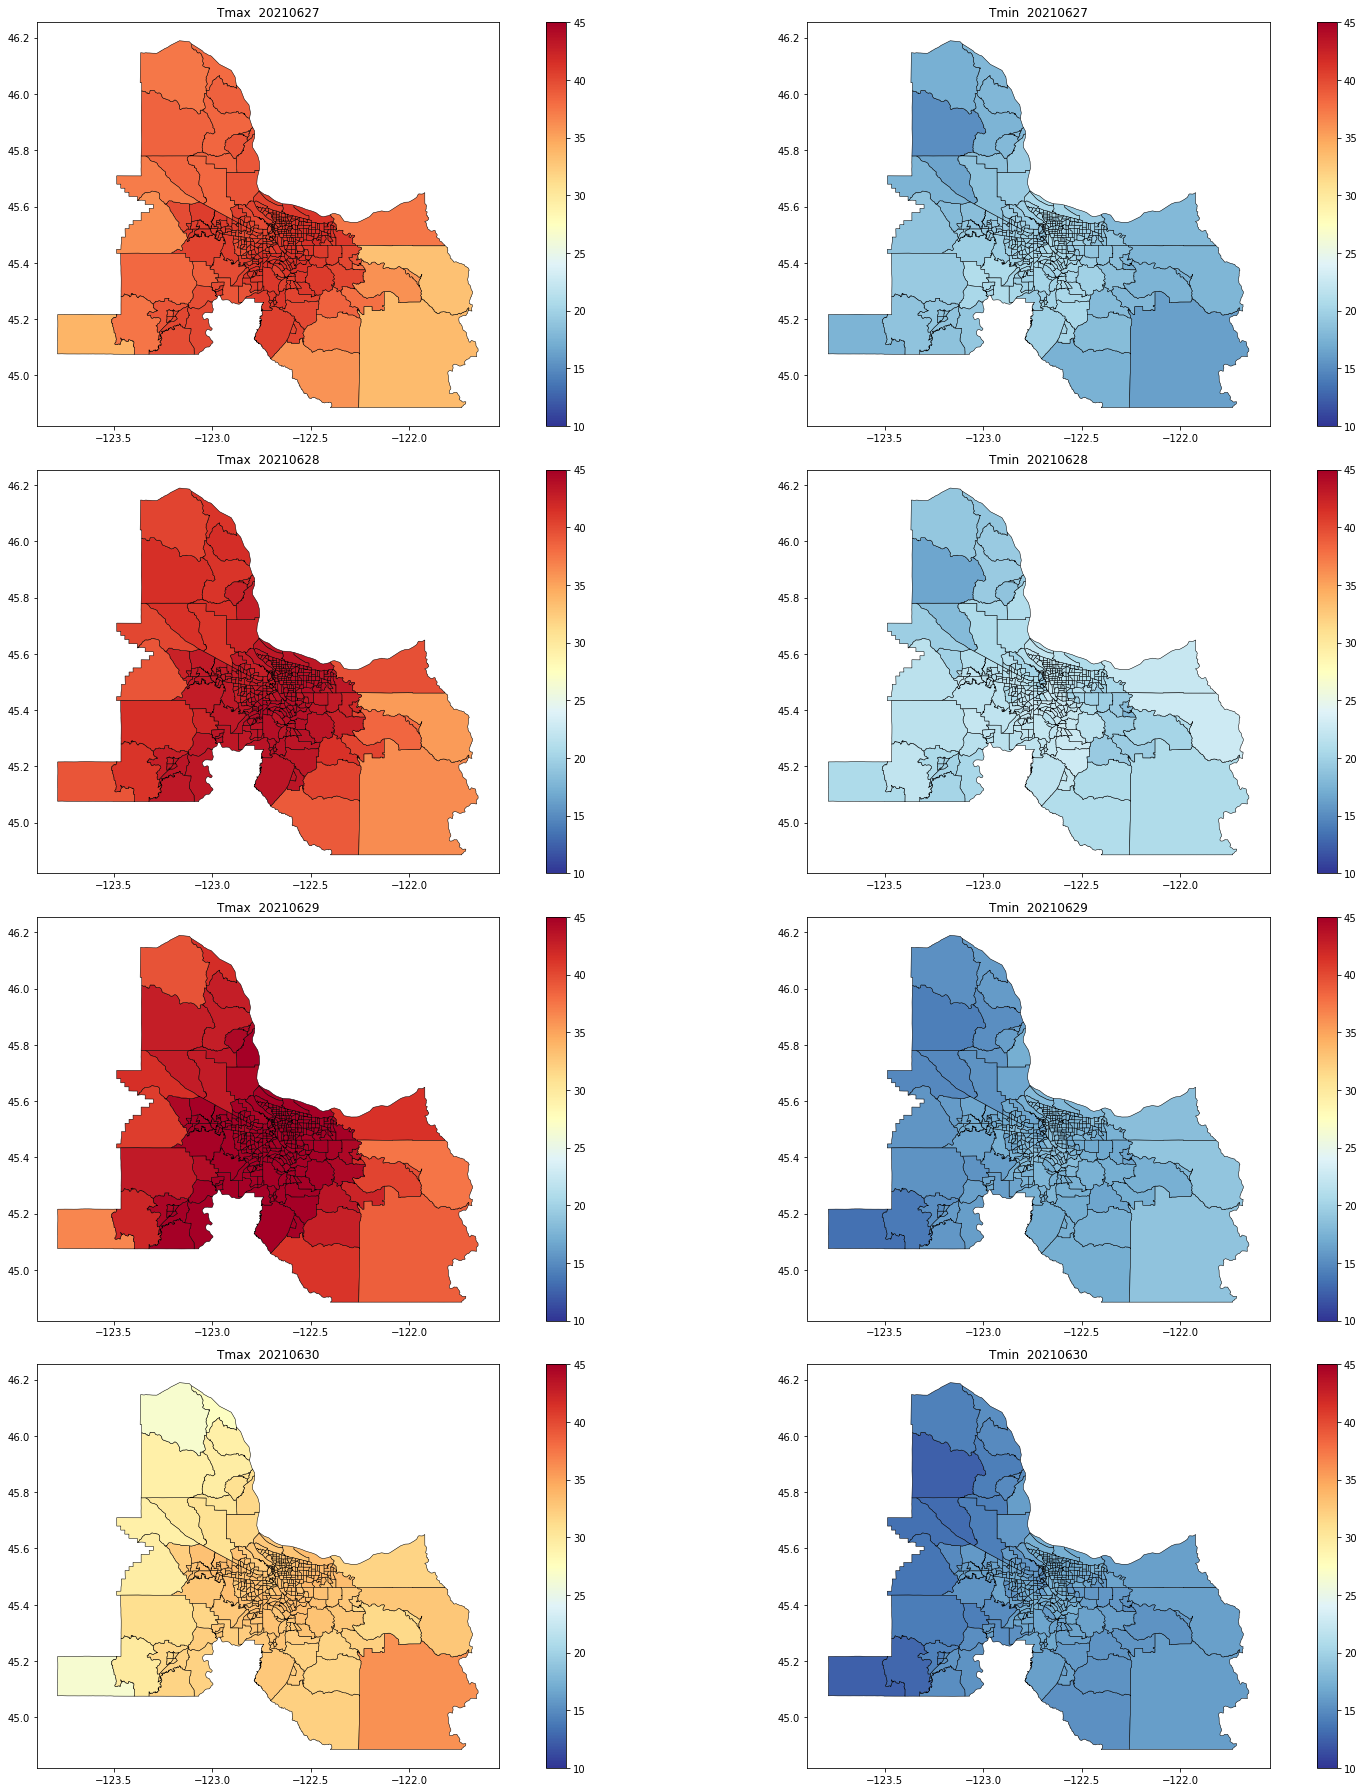

In [62]:
cmap_s = ['RdYlBu_r','RdYlBu_r']
da_4d = xr.concat([tmax_3d, tmin_3d], "var_s")
var_s = ['Tmax', 'Tmin'] 
plot_shp_p(da_4d, var_s, county_2d, shp_gpd.lat_centroid, shp_gpd.lon_centroid, cmap_s, date_s)

In [ ]:
https://www.tomasbeuzen.com/python-for-geospatial-analysis/chapters/chapter1_intro-to-spatial.html
Introduction to Spatial Data